In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import h5py
import torch

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
np.set_printoptions(precision=2, suppress=False)

cuda:0


Building dataset with constant housing in time
Building dataset with constant housing in time
Building dataset with constant housing in time
Building dataset with constant housing in time
Building dataset with constant housing in time


Text(0, 0.5, 'Black')

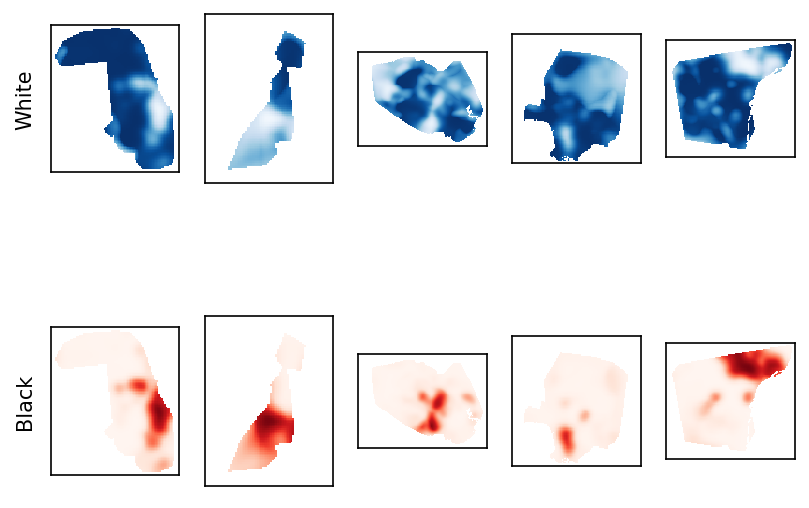

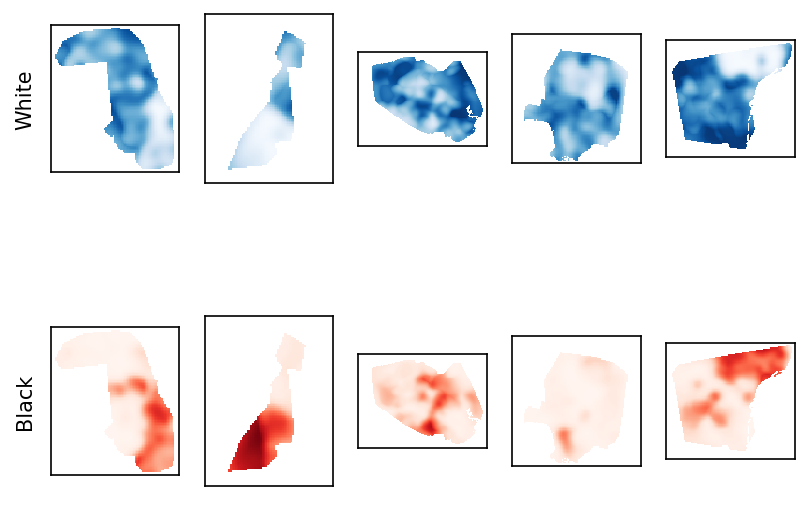

In [2]:
from data_processing import *
from pbnn import *
from torch.utils.data import ConcatDataset

def plot(ax, sample, vmax=None):
    ax[0].pcolormesh(sample['x'], sample['y'], sample['wb0'][0], cmap='Blues', vmax=1, vmin=0)
    ax[1].pcolormesh(sample['x'], sample['y'], sample['wb0'][1], cmap='Reds', vmax=1, vmin=0)
        
    for a in ax:
        a.set_aspect('equal')
        a.set(xticks=[], yticks=[])
    

housing_method='constant'
dataset = ConcatDataset([
    CensusDataset('cook_IL',housing_method=housing_method),
    CensusDataset('fulton_GA',housing_method=housing_method),
    CensusDataset('harris_TX',housing_method=housing_method),
    CensusDataset('la_CA',housing_method=housing_method),
    CensusDataset('wayne_MI',housing_method=housing_method),
])
fig, ax = plt.subplots(2, 5, dpi=150)
for i, ds in enumerate(dataset.datasets):
    ds.validate()
    plot(ax[:, i], dataset[i*40])
    
ax[0,0].set_ylabel(f'White')
ax[1,0].set_ylabel(f'Black')

fig, ax = plt.subplots(2, 5, dpi=150)
for i, ds in enumerate(dataset.datasets):
    ds.validate()
    plot(ax[:, i], dataset[i*40+30])
    
ax[0,0].set_ylabel(f'White')
ax[1,0].set_ylabel(f'Black')

Building dataset with constant housing in time


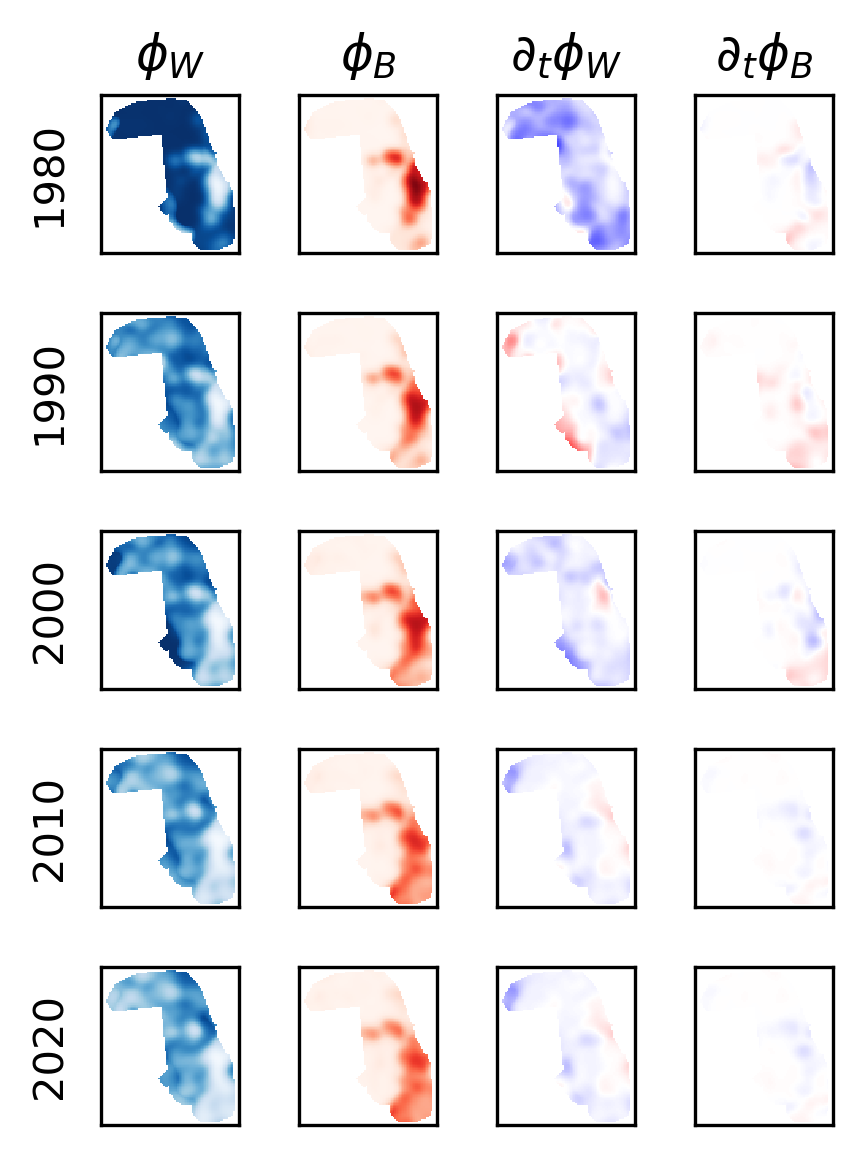

In [3]:
fig, ax = plt.subplots(5, 4, figsize=(3, 4), dpi=300)

county = 'cook_IL'
dataset = CensusDataset(county, housing_method='constant')
dataset.validate()

vmax = 0.1
for i in range(5):
    wb0 = dataset.wb(1980+i*10)
    wb1 = dataset.wb(1980+i*10+1)
    ax[i, 0].pcolormesh(dataset.x, dataset.y, wb0[0], vmin=0, vmax=1, cmap='Blues')
    ax[i, 1].pcolormesh(dataset.x, dataset.y, wb0[1], vmin=0, vmax=1, cmap='Reds')
    ax[i, 2].pcolormesh(dataset.x, dataset.y, wb1[0]-wb0[0], vmin=-vmax, vmax=vmax, cmap='bwr')
    ax[i, 3].pcolormesh(dataset.x, dataset.y, wb1[1]-wb0[1], vmin=-vmax, vmax=vmax, cmap='bwr')
    ax[i,0].set_ylabel(1980+i*10)

for a in ax.flatten():
    a.set(xticks=[], yticks=[], aspect='equal')
    
ax[0,0].set_title('$\phi_W$')
ax[0,1].set_title('$\phi_B$')
ax[0,2].set_title('$\partial_t \phi_W$')
ax[0,3].set_title('$\partial_t \phi_B$')
    
plt.tight_layout()

# Plotting BWR maps of "All White" -> "All Black"

Building dataset with constant housing in time


100%|██████████| 40/40 [00:06<00:00,  5.87it/s]


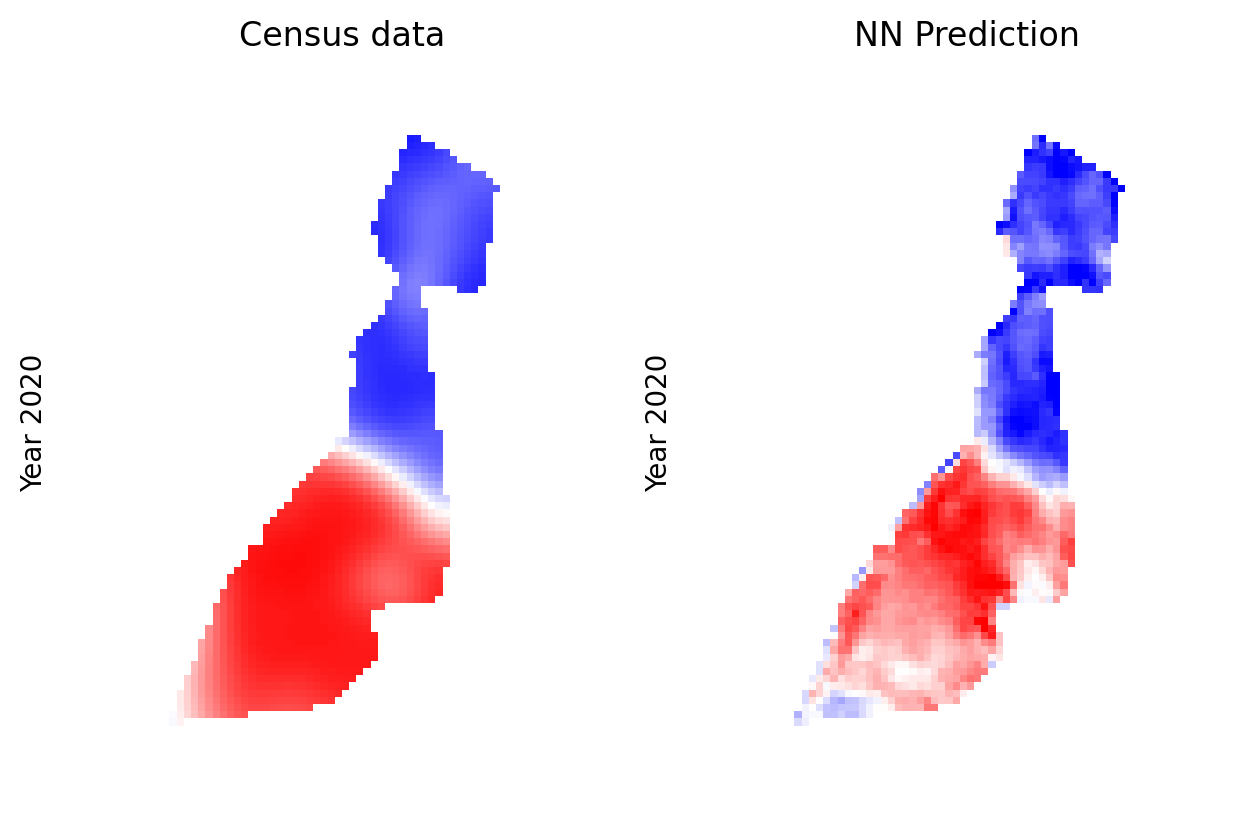

In [4]:
plt.rcParams['axes.linewidth'] = 0

def plot(ax, sample, savename=None):
    w = sample['wb0'][0] * dataset.housing
    b = sample['wb0'][1] * dataset.housing
    if savename is not None:
        np.save(savename, sample['wb0'] * dataset.housing)
    toplot = (w - b) / (w + b)
    ax.pcolormesh(sample['x'], sample['y'], toplot, vmin=-1, vmax=1, cmap='bwr_r')
    ax.set(
        xticks=[],
        yticks=[],
        aspect='equal',
        ylabel=f'Year {sample["t"]:g}'
    )

from data_processing import *
from pbnn import *
from dolfin_problems import *

county = 'fulton_GA'
dataset = CensusDataset(county,
                        get_dolfin=SociohydrodynamicsProblem,
                        housing_method='constant')
dataset.validate()

data_dir = '/home/jcolen/data/sociohydro/decennial/'
info = torch.load(f'models/decennial/SourcedOnlyPBNN.ckpt')
model = DecennialPBNN().to(device)
model.load_state_dict(info['state_dict'], strict=False)
model.train()

t0 = 1980
t1 = 2020
tmax = t1 - t0
dt = 1

dataset.validate()
sample = dataset[0]
mask = sample['mask']

fig, ax = plt.subplots(1, 2, dpi=200)

plot(ax[0], dataset[tmax], savename=f'{data_dir}/{county}/{county}_CensusData')
np.save(f'{data_dir}/{county}/{county}_X', dataset.x)
np.save(f'{data_dir}/{county}/{county}_Y', dataset.y)
np.save(f'{data_dir}/{county}/{county}_mask', dataset.mask)

with torch.no_grad(), d_ad.stop_annotating():
    sample['wb0'] = sample['wb0'].to(device)
    w0, b0, wb = model.simulate(sample, dataset.mesh, tmax, dt=dt)
    sample['wb0']= wb.cpu()
    sample['t'] += tmax

plot(ax[1], sample, savename=f'{data_dir}/{county}/{county}_NNPred')
plot(ax[1], sample)
ax[0].set_title('Census data')
ax[1].set_title('NN Prediction')

plt.tight_layout()

#plt.savefig(f'Figures/PBNN_Prediction_{county}.svg')

Building dataset with constant housing in time


100%|██████████| 40/40 [00:11<00:00,  3.59it/s]


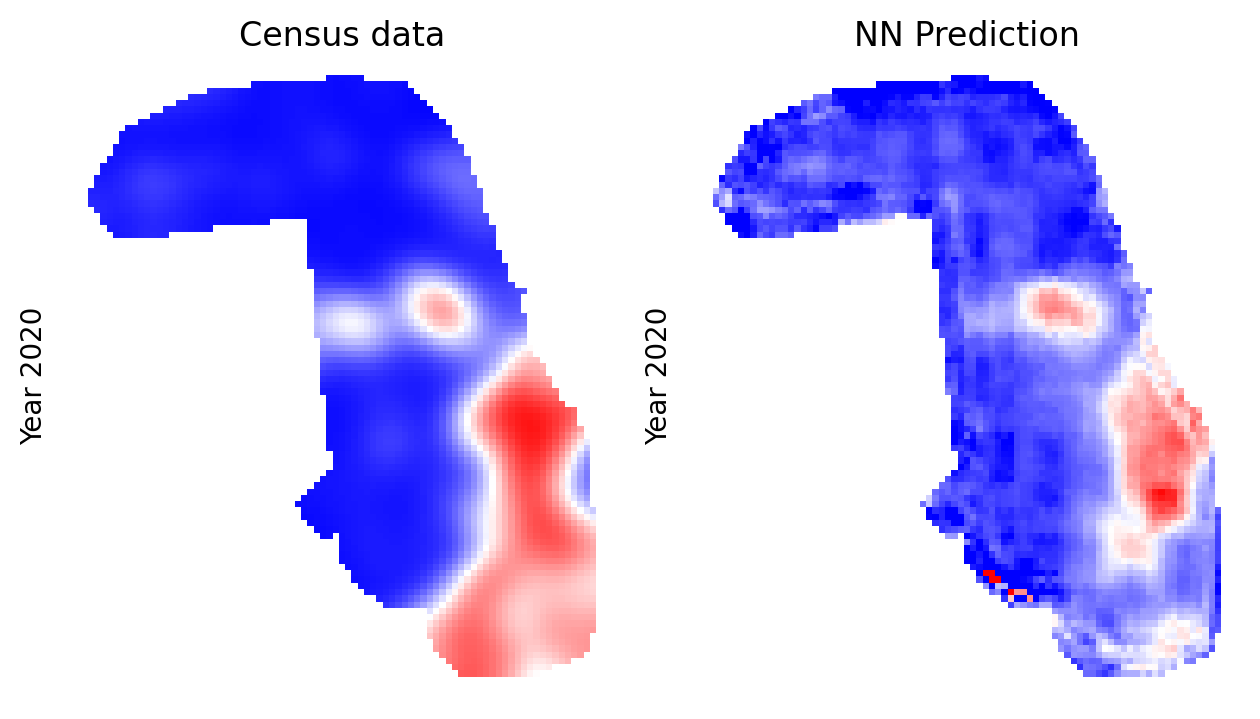

In [5]:
plt.rcParams['axes.linewidth'] = 0

def plot(ax, sample, savename=None):
    w = sample['wb0'][0] * dataset.housing
    b = sample['wb0'][1] * dataset.housing
    if savename is not None:
        np.save(savename, sample['wb0'] * dataset.housing)
    toplot = (w - b) / (w + b)
    ax.pcolormesh(sample['x'], sample['y'], toplot, vmin=-1, vmax=1, cmap='bwr_r')
    ax.set(
        xticks=[],
        yticks=[],
        aspect='equal',
        ylabel=f'Year {sample["t"]:g}'
    )

from data_processing import *
from pbnn import *
from dolfin_problems import *

county = 'cook_IL'
dataset = CensusDataset(county,
                        get_dolfin=SociohydrodynamicsProblem,
                        housing_method='constant')
dataset.validate()

data_dir = '/home/jcolen/data/sociohydro/decennial/'
info = torch.load(f'models/decennial/SourcedOnlyPBNN.ckpt')
model = DecennialPBNN().to(device)
model.load_state_dict(info['state_dict'], strict=False)
model.train()

t0 = 1980
t1 = 2020
tmax = t1 - t0
dt = 1

dataset.validate()
sample = dataset[0]
mask = sample['mask']

fig, ax = plt.subplots(1, 2, dpi=200)

plot(ax[0], dataset[tmax], savename=f'{data_dir}/{county}/{county}_CensusData')
np.save(f'{data_dir}/{county}/{county}_X', dataset.x)
np.save(f'{data_dir}/{county}/{county}_Y', dataset.y)
np.save(f'{data_dir}/{county}/{county}_mask', dataset.mask)

with torch.no_grad(), d_ad.stop_annotating():
    sample['wb0'] = sample['wb0'].to(device)
    w0, b0, wb = model.simulate(sample, dataset.mesh, tmax, dt=dt)
    sample['wb0']= wb.cpu()
    sample['t'] += tmax

plot(ax[1], sample, savename=f'{data_dir}/{county}/{county}_NNPred')
plot(ax[1], sample)
ax[0].set_title('Census data')
ax[1].set_title('NN Prediction')

plt.tight_layout()

plt.savefig(f'Figures/PBNN_Prediction_{county}.svg')

Building dataset with constant housing in time


100%|██████████| 40/40 [00:25<00:00,  1.59it/s]


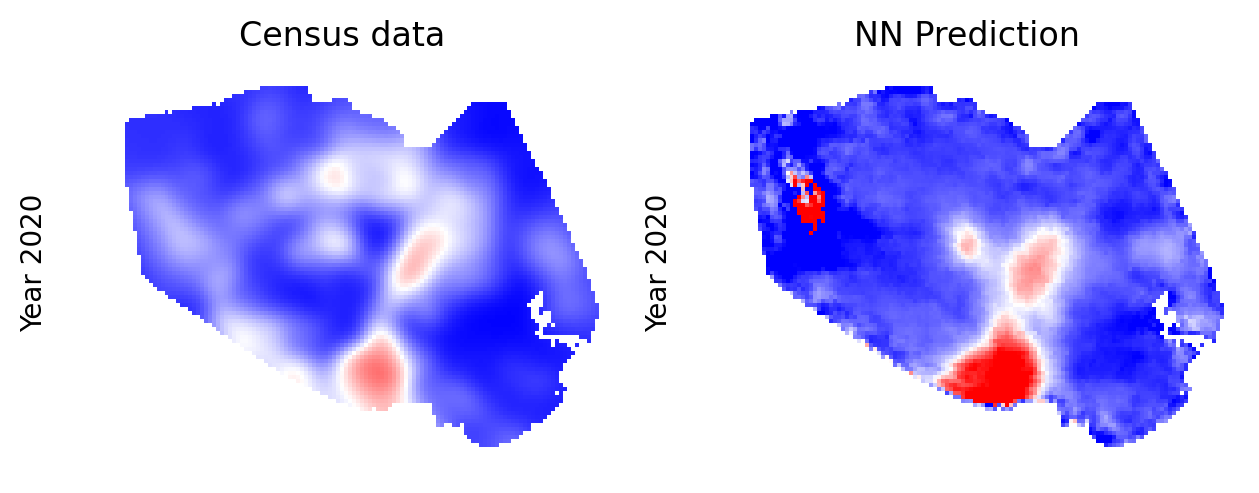

In [6]:
plt.rcParams['axes.linewidth'] = 0

def plot(ax, sample, savename=None):
    w = sample['wb0'][0] * dataset.housing
    b = sample['wb0'][1] * dataset.housing
    if savename is not None:
        np.save(savename, sample['wb0'] * dataset.housing)
    toplot = (w - b) / (w + b)
    ax.pcolormesh(sample['x'], sample['y'], toplot, vmin=-1, vmax=1, cmap='bwr_r')
    ax.set(
        xticks=[],
        yticks=[],
        aspect='equal',
        ylabel=f'Year {sample["t"]:g}'
    )

from data_processing import *
from pbnn import *
from dolfin_problems import *

county = 'harris_TX'
dataset = CensusDataset(county,
                        get_dolfin=SociohydrodynamicsProblem,
                        housing_method='constant')
dataset.validate()

data_dir = '/home/jcolen/data/sociohydro/decennial/'
info = torch.load(f'models/decennial/SourcedOnlyPBNN.ckpt')
model = DecennialPBNN().to(device)
model.load_state_dict(info['state_dict'], strict=False)
model.train()

t0 = 1980
t1 = 2020
tmax = t1 - t0
dt = 1

dataset.validate()
sample = dataset[0]
mask = sample['mask']

fig, ax = plt.subplots(1, 2, dpi=200)

plot(ax[0], dataset[tmax], savename=f'{data_dir}/{county}/{county}_CensusData')
np.save(f'{data_dir}/{county}/{county}_X', dataset.x)
np.save(f'{data_dir}/{county}/{county}_Y', dataset.y)
np.save(f'{data_dir}/{county}/{county}_mask', dataset.mask)

with torch.no_grad(), d_ad.stop_annotating():
    sample['wb0'] = sample['wb0'].to(device)
    w0, b0, wb = model.simulate(sample, dataset.mesh, tmax, dt=dt)
    sample['wb0']= wb.cpu()
    sample['t'] += tmax

plot(ax[1], sample, savename=f'{data_dir}/{county}/{county}_NNPred')
plot(ax[1], sample)
ax[0].set_title('Census data')
ax[1].set_title('NN Prediction')

plt.tight_layout()

plt.savefig(f'Figures/PBNN_Prediction_{county}.svg')

Building dataset with constant housing in time


100%|██████████| 40/40 [00:13<00:00,  3.01it/s]


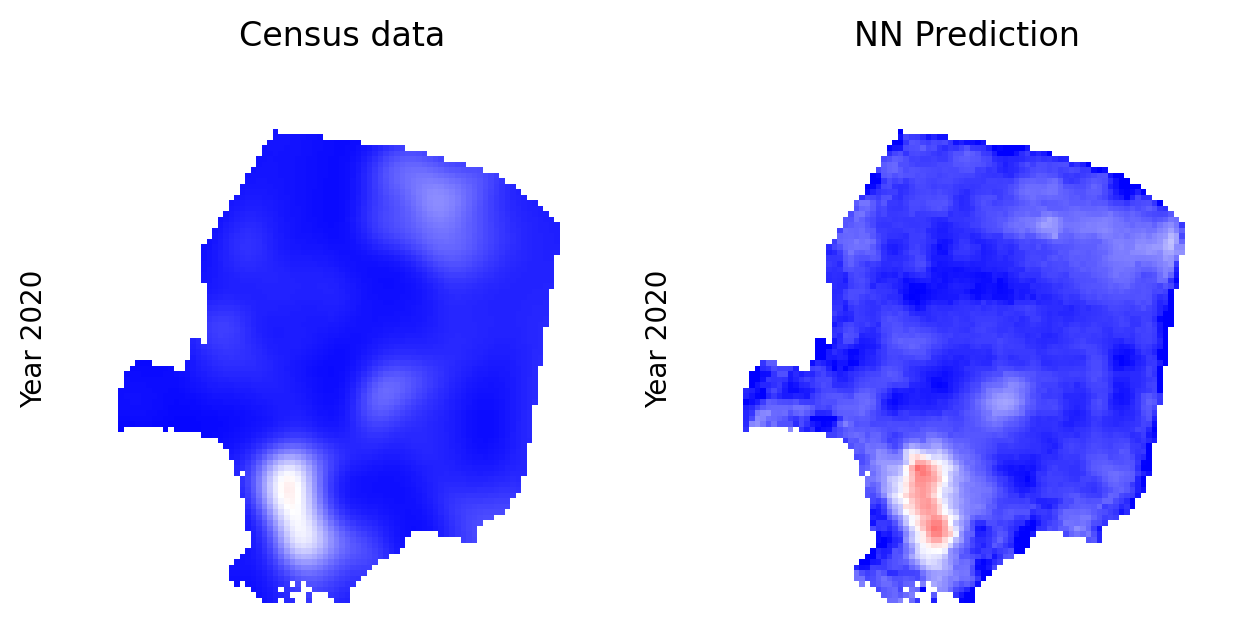

In [7]:
plt.rcParams['axes.linewidth'] = 0

def plot(ax, sample, savename=None):
    w = sample['wb0'][0] * dataset.housing
    b = sample['wb0'][1] * dataset.housing
    if savename is not None:
        np.save(savename, sample['wb0'] * dataset.housing)
    toplot = (w - b) / (w + b)
    ax.pcolormesh(sample['x'], sample['y'], toplot, vmin=-1, vmax=1, cmap='bwr_r')
    ax.set(
        xticks=[],
        yticks=[],
        aspect='equal',
        ylabel=f'Year {sample["t"]:g}'
    )

from data_processing import *
from pbnn import *
from dolfin_problems import *

county = 'la_CA'
dataset = CensusDataset(county,
                        get_dolfin=SociohydrodynamicsProblem,
                        housing_method='constant')
dataset.validate()

data_dir = '/home/jcolen/data/sociohydro/decennial/'
info = torch.load(f'models/decennial/SourcedOnlyPBNN.ckpt')
model = DecennialPBNN().to(device)
model.load_state_dict(info['state_dict'], strict=False)
model.train()

t0 = 1980
t1 = 2020
tmax = t1 - t0
dt = 1

dataset.validate()
sample = dataset[0]
mask = sample['mask']

fig, ax = plt.subplots(1, 2, dpi=200)

plot(ax[0], dataset[tmax], savename=f'{data_dir}/{county}/{county}_CensusData')
np.save(f'{data_dir}/{county}/{county}_X', dataset.x)
np.save(f'{data_dir}/{county}/{county}_Y', dataset.y)
np.save(f'{data_dir}/{county}/{county}_mask', dataset.mask)

with torch.no_grad(), d_ad.stop_annotating():
    sample['wb0'] = sample['wb0'].to(device)
    w0, b0, wb = model.simulate(sample, dataset.mesh, tmax, dt=dt)
    sample['wb0']= wb.cpu()
    sample['t'] += tmax

plot(ax[1], sample, savename=f'{data_dir}/{county}/{county}_NNPred')
plot(ax[1], sample)
ax[0].set_title('Census data')
ax[1].set_title('NN Prediction')

plt.tight_layout()

plt.savefig(f'Figures/PBNN_Prediction_{county}.svg')

# Plotting dynamics of white and black

Building dataset with constant housing in time


  0%|          | 0/40 [00:00<?, ?it/s]

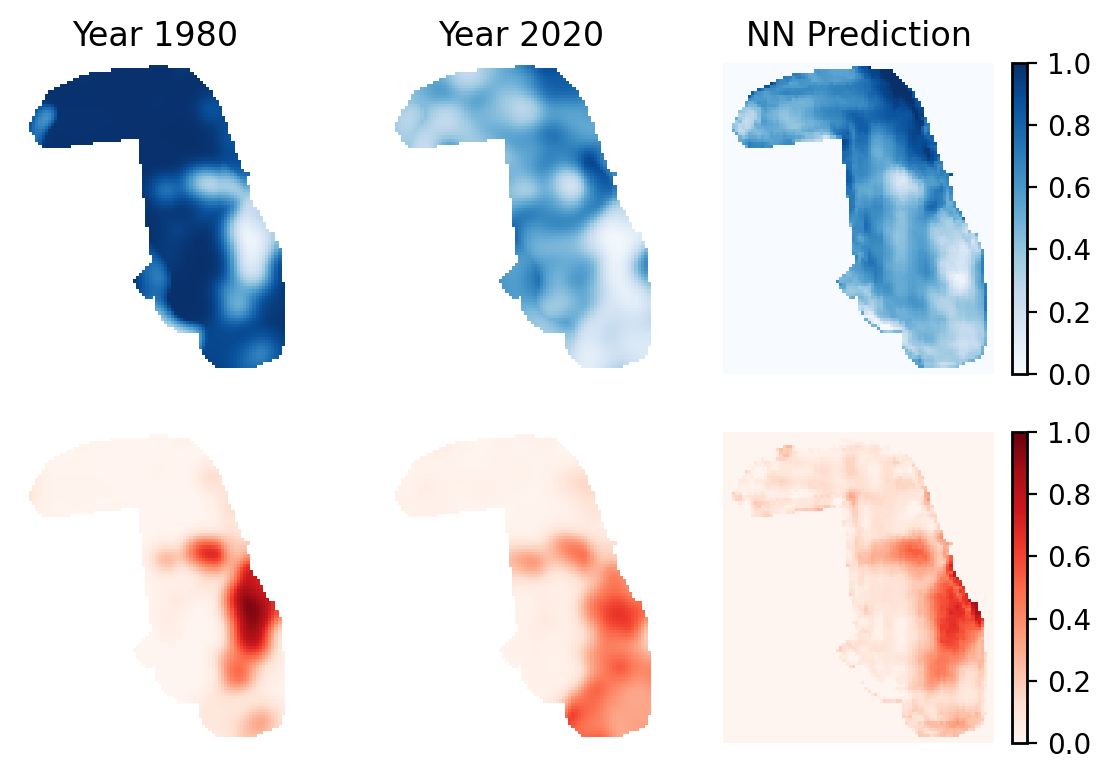

In [29]:
def plot(ax, sample, housing=None, vmax=1, colorbar=False):
    if housing is not None:
        sample['wb0'] *= housing
    imW = ax[0].pcolormesh(sample['x'], sample['y'], sample['wb0'][0], cmap='Blues', vmax=vmax, vmin=0)
    imB = ax[1].pcolormesh(sample['x'], sample['y'], sample['wb0'][1], cmap='Reds', vmax=vmax, vmin=0)
        
    for a in ax:
        a.set_aspect('equal')
        a.set(xticks=[], yticks=[])
    
    ax[0].set_title(f'Year {sample["t"]:g}')
    if colorbar:
        cax1 = plt.colorbar(imW, ax=ax[0])
        cax2 = plt.colorbar(imB, ax=ax[1])
    ax[0].axis('off')
    ax[1].axis('off')

from data_processing import *
from pbnn import *
from dolfin_problems import *

plt.rcParams['axes.linewidth'] = 1

pipeline=9112009
model = SourcedOnlyPBNN().to(device)
info = torch.load(f'data/pipeline_{pipeline}/constant/{model.__class__.__name__}.ckpt', map_location='cpu')
model.load_state_dict(info['state_dict'])
model.train()

t0 = 1980
t1 = 2020
tmax = t1 - t0
dt = 1


county = 'cook_IL'
dataset = CensusDataset(county,
                        get_dolfin=SociohydrodynamicsProblem,
                        housing_method='constant')
dataset.validate()

fig, ax = plt.subplots(2, 3, dpi=200)

plot(ax[:, 0], dataset[0])#, dataset.housing, vmax=8000)
plot(ax[:, 1], dataset[tmax])#, dataset.housing, vmax=8000)
sample = dataset[0]
with torch.no_grad(), d_ad.stop_annotating():
    sample['wb0'] = sample['wb0'].to(device)
    w0, b0, wb = model.simulate(sample, dataset.mesh, tmax, dt=dt)
    sample['wb0']= wb.cpu()
    sample['t'] += tmax

plot(ax[:, 2], sample, colorbar=True)#, dataset.housing, vmax=8000, colorbar=True)
ax[0, 2].set_title('NN Prediction')

ax[0,0].set_ylabel('White')
ax[1,0].set_ylabel('Black')
plt.tight_layout()

Building dataset with constant housing in time


  0%|          | 0/40 [00:00<?, ?it/s]

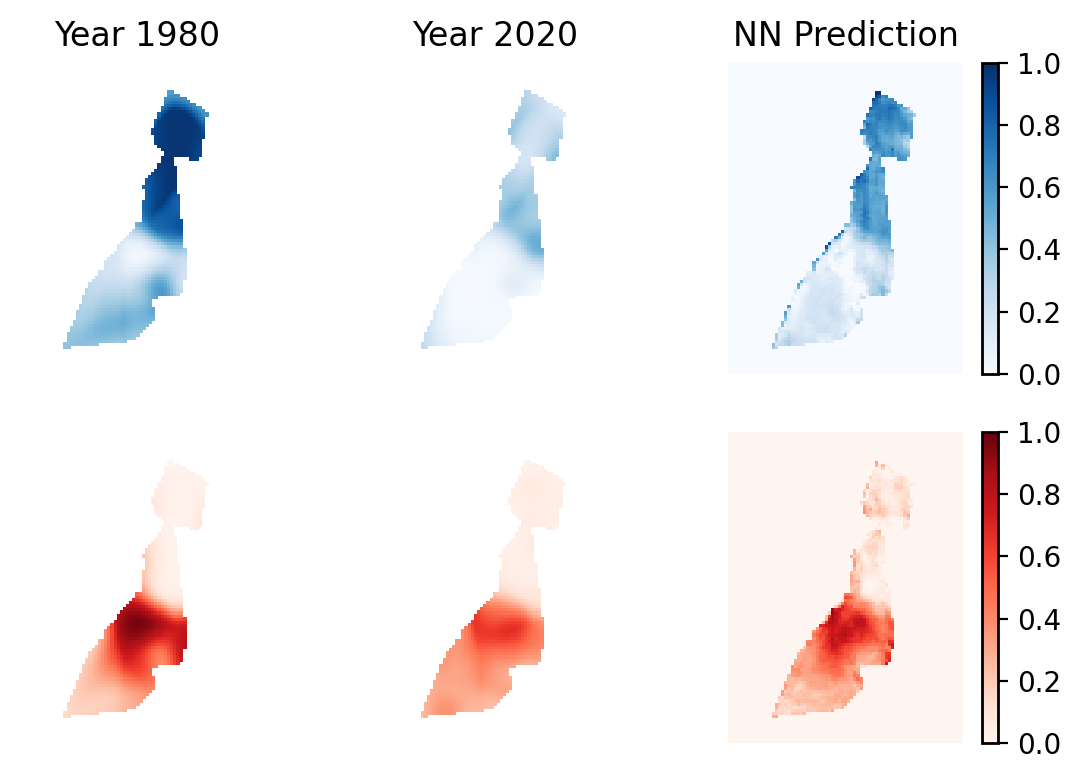

In [28]:
def plot(ax, sample, housing=None, vmax=1, colorbar=False):
    if housing is not None:
        sample['wb0'] *= housing
    imW = ax[0].pcolormesh(sample['x'], sample['y'], sample['wb0'][0], cmap='Blues', vmax=vmax, vmin=0)
    imB = ax[1].pcolormesh(sample['x'], sample['y'], sample['wb0'][1], cmap='Reds', vmax=vmax, vmin=0)
        
    for a in ax:
        a.set_aspect('equal')
        a.set(xticks=[], yticks=[])
    
    ax[0].set_title(f'Year {sample["t"]:g}')
    if colorbar:
        cax1 = plt.colorbar(imW, ax=ax[0])
        cax2 = plt.colorbar(imB, ax=ax[1])
    ax[0].axis('off')
    ax[1].axis('off')

from data_processing import *
from pbnn import *
from dolfin_problems import *

plt.rcParams['axes.linewidth'] = 1

pipeline=9112009
model = SourcedOnlyPBNN().to(device)
info = torch.load(f'data/pipeline_{pipeline}/constant/{model.__class__.__name__}.ckpt', map_location='cpu')
model.load_state_dict(info['state_dict'])
model.train()

t0 = 1980
t1 = 2020
tmax = t1 - t0
dt = 1


county = 'fulton_GA'
dataset = CensusDataset(county,
                        get_dolfin=SociohydrodynamicsProblem,
                        housing_method='constant')
dataset.validate()

fig, ax = plt.subplots(2, 3, dpi=200)

plot(ax[:, 0], dataset[0])
plot(ax[:, 1], dataset[tmax])
sample = dataset[0]
with torch.no_grad(), d_ad.stop_annotating():
    sample['wb0'] = sample['wb0'].to(device)
    w0, b0, wb = model.simulate(sample, dataset.mesh, tmax, dt=dt)
    sample['wb0']= wb.cpu()
    sample['t'] += tmax

plot(ax[:, 2], sample, colorbar=True)
ax[0, 2].set_title('NN Prediction')

ax[0,0].set_ylabel('White')
ax[1,0].set_ylabel('Black')
plt.tight_layout()

Building dataset with constant housing in time


  0%|          | 0/40 [00:00<?, ?it/s]

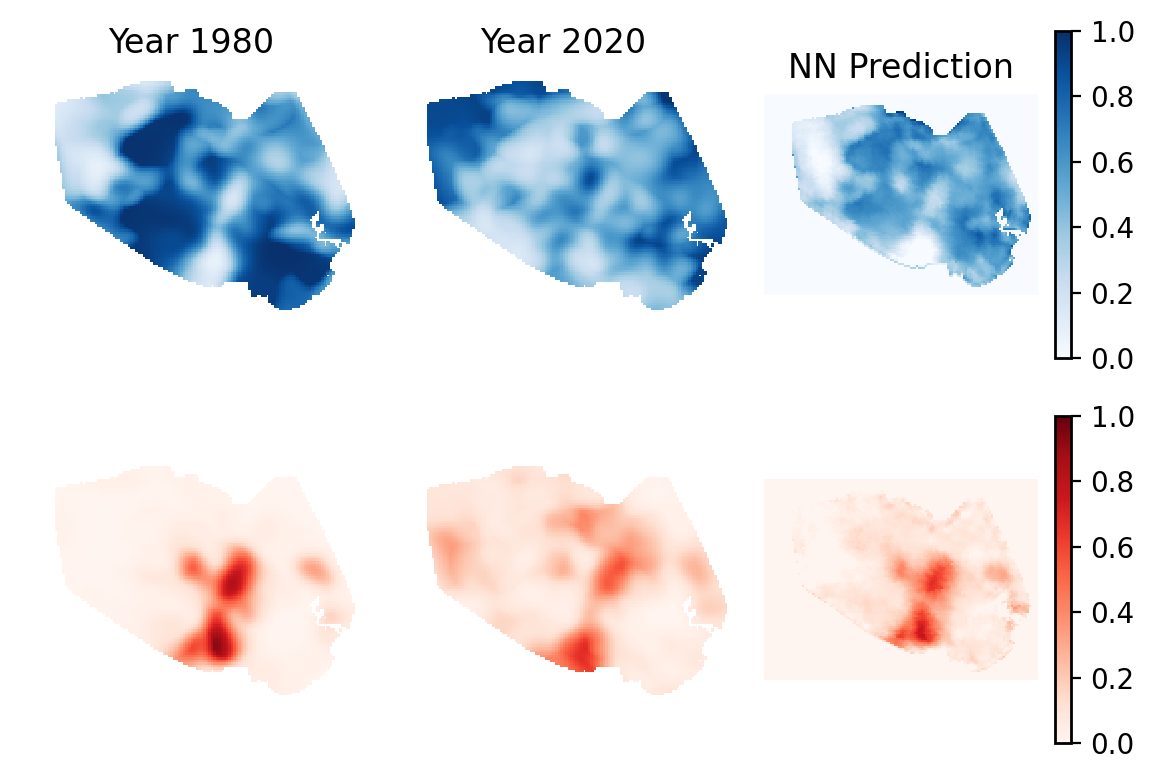

In [22]:
def plot(ax, sample, housing=None, vmax=1, colorbar=False):
    if housing is not None:
        sample['wb0'] *= housing
    imW = ax[0].pcolormesh(sample['x'], sample['y'], sample['wb0'][0], cmap='Blues', vmax=vmax, vmin=0)
    imB = ax[1].pcolormesh(sample['x'], sample['y'], sample['wb0'][1], cmap='Reds', vmax=vmax, vmin=0)
        
    for a in ax:
        a.set_aspect('equal')
        a.set(xticks=[], yticks=[])
    
    ax[0].set_title(f'Year {sample["t"]:g}')
    if colorbar:
        cax1 = plt.colorbar(imW, ax=ax[0])
        cax2 = plt.colorbar(imB, ax=ax[1])
    ax[0].axis('off')
    ax[1].axis('off')

from data_processing import *
from pbnn import *
from dolfin_problems import *

plt.rcParams['axes.linewidth'] = 1

pipeline=9112009
model = SourcedOnlyPBNN().to(device)
info = torch.load(f'data/pipeline_{pipeline}/constant/{model.__class__.__name__}.ckpt', map_location='cpu')
model.load_state_dict(info['state_dict'])
model.train()

t0 = 1980
t1 = 2020
tmax = t1 - t0
dt = 1


county = 'harris_TX'
dataset = CensusDataset(county,
                        get_dolfin=SociohydrodynamicsProblem,
                        housing_method='constant')
dataset.validate()

fig, ax = plt.subplots(2, 3, dpi=200)

plot(ax[:, 0], dataset[0])
plot(ax[:, 1], dataset[tmax])
sample = dataset[0]
with torch.no_grad(), d_ad.stop_annotating():
    sample['wb0'] = sample['wb0'].to(device)
    w0, b0, wb = model.simulate(sample, dataset.mesh, tmax, dt=dt)
    sample['wb0']= wb.cpu()
    sample['t'] += tmax

plot(ax[:, 2], sample, colorbar=True)
ax[0, 2].set_title('NN Prediction')

ax[0,0].set_ylabel('White')
ax[1,0].set_ylabel('Black')
plt.tight_layout()

Building dataset with constant housing in time


  0%|          | 0/40 [00:00<?, ?it/s]

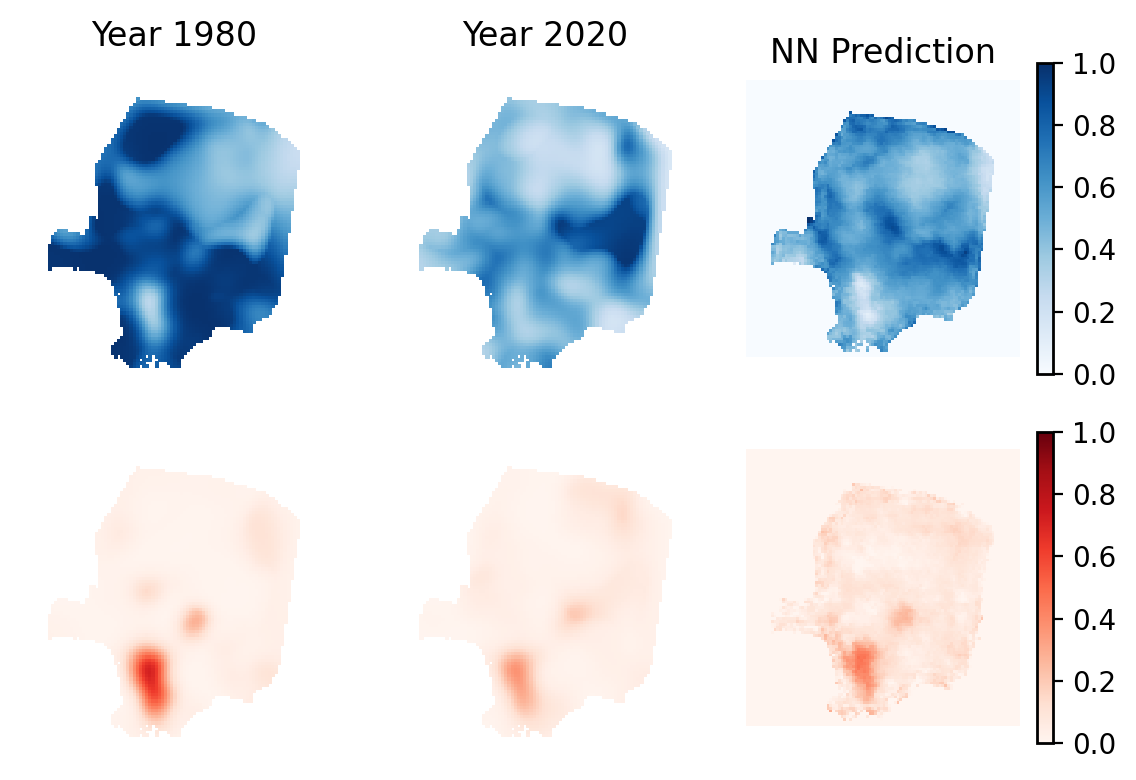

In [23]:
def plot(ax, sample, housing=None, vmax=1, colorbar=False):
    if housing is not None:
        sample['wb0'] *= housing
    imW = ax[0].pcolormesh(sample['x'], sample['y'], sample['wb0'][0], cmap='Blues', vmax=vmax, vmin=0)
    imB = ax[1].pcolormesh(sample['x'], sample['y'], sample['wb0'][1], cmap='Reds', vmax=vmax, vmin=0)
        
    for a in ax:
        a.set_aspect('equal')
        a.set(xticks=[], yticks=[])
    
    ax[0].set_title(f'Year {sample["t"]:g}')
    if colorbar:
        cax1 = plt.colorbar(imW, ax=ax[0])
        cax2 = plt.colorbar(imB, ax=ax[1])
    ax[0].axis('off')
    ax[1].axis('off')

from data_processing import *
from pbnn import *
from dolfin_problems import *

plt.rcParams['axes.linewidth'] = 1

pipeline=9112009
model = SourcedOnlyPBNN().to(device)
info = torch.load(f'data/pipeline_{pipeline}/constant/{model.__class__.__name__}.ckpt', map_location='cpu')
model.load_state_dict(info['state_dict'])
model.train()

t0 = 1980
t1 = 2020
tmax = t1 - t0
dt = 1


county = 'la_CA'
dataset = CensusDataset(county,
                        get_dolfin=SociohydrodynamicsProblem,
                        housing_method='constant')
dataset.validate()

fig, ax = plt.subplots(2, 3, dpi=200)

plot(ax[:, 0], dataset[0])
plot(ax[:, 1], dataset[tmax])
sample = dataset[0]
with torch.no_grad(), d_ad.stop_annotating():
    sample['wb0'] = sample['wb0'].to(device)
    w0, b0, wb = model.simulate(sample, dataset.mesh, tmax, dt=dt)
    sample['wb0']= wb.cpu()
    sample['t'] += tmax

plot(ax[:, 2], sample, colorbar=True)
ax[0, 2].set_title('NN Prediction')

ax[0,0].set_ylabel('White')
ax[1,0].set_ylabel('Black')
plt.tight_layout()

# Build a spatial saliency map

In [8]:
dataset = ConcatDataset([
    CensusDataset('cook_IL',housing_method=housing_method),
    CensusDataset('fulton_GA',housing_method=housing_method),
    CensusDataset('harris_TX',housing_method=housing_method),
    CensusDataset('la_CA',housing_method=housing_method),
])

info = torch.load(f'models/decennial/SourcedOnlyPBNN.ckpt')

model = DecennialPBNN().to(device)
model.load_state_dict(info['state_dict'], strict=False)
model.train()

for ds in dataset.datasets:
    print(dataset)
    compute_saliency(model, ds, device, 'models/decennial/SourcedOnlyPBNN')

Building dataset with constant housing in time
Building dataset with constant housing in time
Building dataset with constant housing in time
Building dataset with constant housing in time


100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


100%|██████████| 40/40 [01:20<00:00,  2.01s/it]


100%|██████████| 40/40 [01:49<00:00,  2.74s/it]


100%|██████████| 40/40 [00:45<00:00,  1.13s/it]
